In [ ]:
from huggingface_hub import hf_hub_download

rna = hf_hub_download(
    "rendeirolab/lazyslide-data", "GTEx_artery_RNA.h5ad", repo_type="dataset"
)
wsi_features = hf_hub_download(
    "rendeirolab/lazyslide-data", "agg_conch_features.h5ad", repo_type="dataset"
)

In [ ]:
import anndata as ad
import scanpy as sc

rna = ad.read_h5ad(rna)
wsi_features = ad.read_h5ad(wsi_features)

<Axes: xlabel='Pathology Categories', ylabel='calcification'>

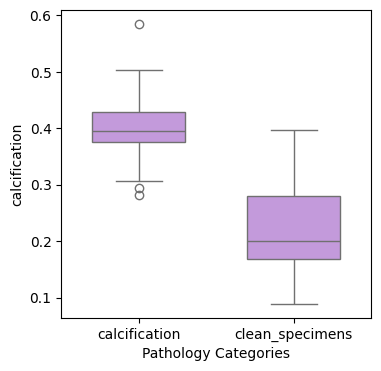

In [ ]:
import seaborn as sns

sns.boxplot(
    data=wsi_features.obs,
    x="Pathology Categories",
    y="calcification",
    color="#C68FE6",
    width=0.6,
)

In [ ]:
def run_umap(adata):
    sc.pp.scale(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)


run_umap(rna)
run_umap(wsi_features)

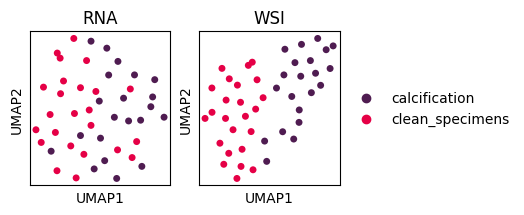

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(4, 2))
opts = dict(
    color="Pathology Categories", palette=["#4F1C51", "#E50046"], size=100, show=False
)

sc.pl.umap(rna, ax=axes[0], legend_loc=None, **opts)
sc.pl.umap(wsi_features, ax=axes[1], **opts)
axes[0].set_title("RNA")
axes[1].set_title("WSI")
plt.show(fig)

In [ ]:
import muon as mu

mdata = mu.MuData({"wsi": wsi_features, "rna": rna})
mu.tl.mofa(mdata, verbose=False)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


/home/runner/work/lazyslide-tutorials/lazyslide-tutorials/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/runner/work/lazyslide-tutorials/lazyslide-tutorials/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/home/runner/work/lazyslide-tutorials/lazyslide-tu

Loaded view='wsi' group='group1' with N=45 samples and D=512 features...
Loaded view='rna' group='group1' with N=45 samples and D=31439 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (wsi): gaussian
- View 1 (rna): gaussian






######################################
## Training the model with seed 1 ##
######################################





Converged!



#######################
## Training finished ##
#######################


Saving model in /tmp/mofa_20250828-192914.hdf5...


Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].


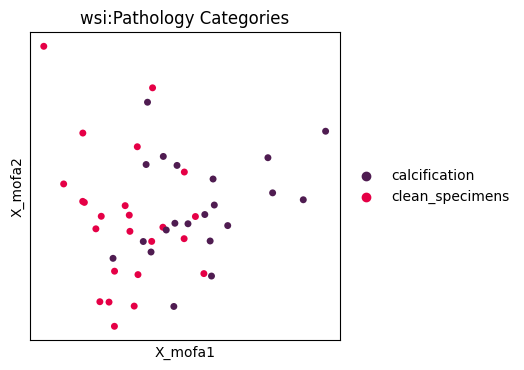

In [ ]:
mu.pl.mofa(
    mdata, color="wsi:Pathology Categories", palette=["#4F1C51", "#E50046"], size=100
)

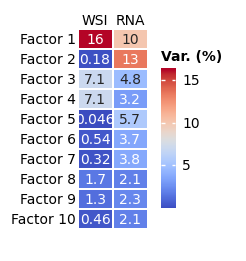

In [ ]:
import numpy as np
import marsilea as ma

loadings = mdata.uns["mofa"]["variance"]

h = ma.Heatmap(
    np.array([loadings["wsi"], loadings["rna"]]).T,
    annot=True,
    cbar_kws={"width": 1, "height": 10},
    width=0.7,
    height=2,
    linewidth=0.1,
    label="Var. (%)",
)
h.add_top(ma.plotter.Labels(["WSI", "RNA"], rotation=0))
h.add_left(ma.plotter.Labels([f"Factor {i}" for i in np.arange(10) + 1]))
h.add_legends(box_padding=1)
h.render()

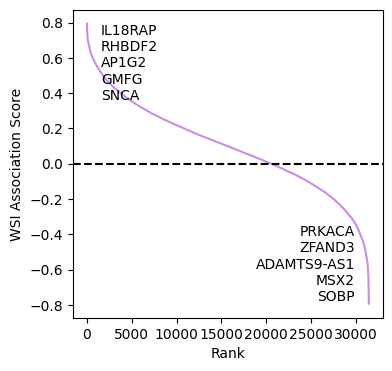

In [ ]:
import lazyslide as zs

linker = zs.tl.RNALinker(wsi_features, rna)
linker.associate(method="spearman", score_key="calcification")
linker.plot_rank(gene_name="Description")
genes = linker.associated_genes(100, gene_name="Description")

In [ ]:
import pandas as pd

decoupler_input = pd.concat([genes["top"], genes["bottom"]]).T
decoupler_input

Description,IL18RAP,RHBDF2,AP1G2,GMFG,SNCA,PLA2G7,ENSG00000234389,NPL,ARL4C,RASAL3,...,ENSG00000268798,RBPMS2,KCTD1,MCAM,MIR325HG,PRKACA,ZFAND3,ADAMTS9-AS1,MSX2,SOBP
association_score,0.793149,0.781159,0.781028,0.780896,0.778656,0.7764,0.77632,0.774967,0.769565,0.767062,...,-0.69776,-0.699209,-0.703821,-0.731489,-0.735968,-0.744005,-0.748617,-0.753491,-0.77668,-0.793412


In [ ]:
import decoupler as dc

msigdb = dc.op.resource("MSigDB")  # Use MSigDB
markers = msigdb.rename(columns={"geneset": "source", "genesymbol": "target"})[
    msigdb["collection"] == "go_molecular_function"
][["source", "target"]].drop_duplicates()  # Filter for GO Molecular Function

acts, padj = dc.mt.ulm(data=decoupler_input, net=markers, tmin=0)

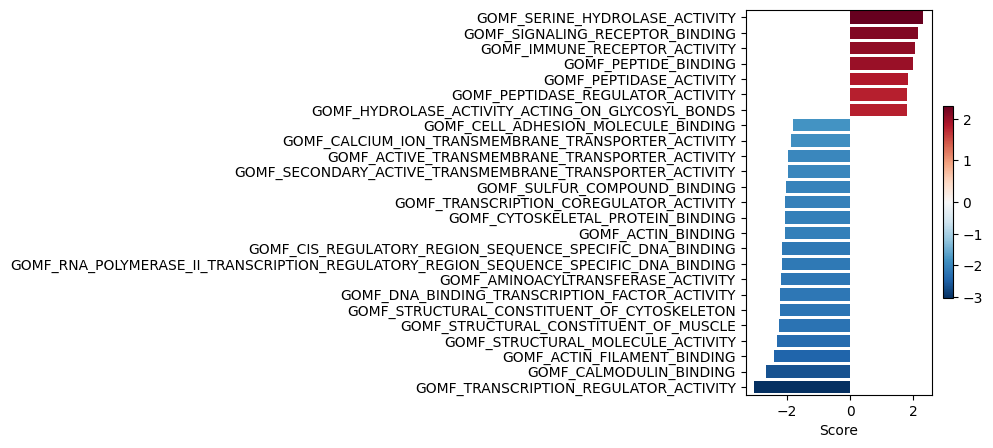

In [ ]:
dc.pl.barplot(data=acts, name="association_score", top=25, figsize=(3, 5))

In [ ]:
import scanpy as sc

sc.tl.rank_genes_groups(rna, "Pathology Categories", method="wilcoxon")
df = sc.get.rank_genes_groups_df(rna, "calcification").sort_values("scores")

decoupler_input_rna = pd.concat([df.head(100), df.tail(100)])[["names", "scores"]]
decoupler_input_rna["names"] = decoupler_input_rna["names"].map(
    rna.var["Description"].to_dict()
)
decoupler_input_rna = decoupler_input_rna.set_index("names").T

... storing 'Description' as categorical


In [ ]:
acts, padj = dc.mt.ulm(data=decoupler_input_rna, net=markers, tmin=0)

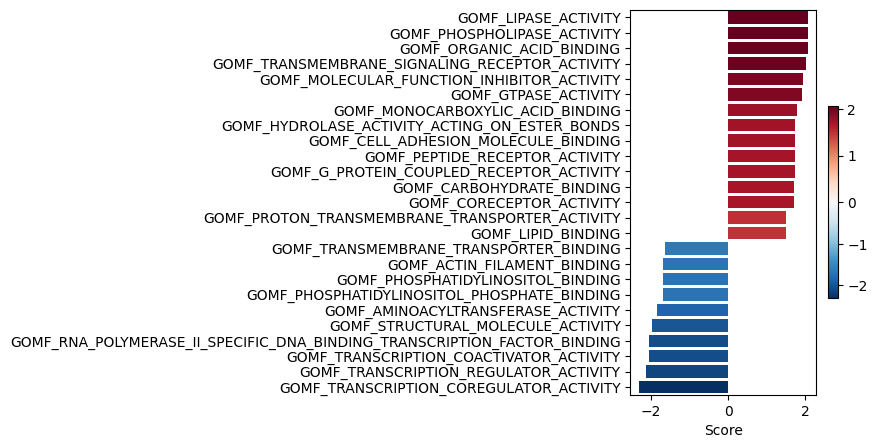

In [ ]:
dc.pl.barplot(data=acts, name="scores", top=25, figsize=(3, 5))